In [ ]:
# Data processing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

# Models

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [ ]:
# Connection to google drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from os import path
path_folder = '/content/drive/MyDrive/Sleep_classifier/'

In [ ]:
# Paths to subjects data
# Female
path_subject_f01 = path.join(path_folder, 'alessandra_20220601_182359.csv')
path_subject_f02 = path.join(path_folder, 'aurora_20220601_180419.csv')
path_subject_f03 = path.join(path_folder, 'benedetta_20220601_184141.csv')
path_subject_f04 = path.join(path_folder, 'chloe_20220601_165046.csv')
path_subject_f05 = path.join(path_folder, 'giulia_20220601_171812.csv')
path_subject_f06 = path.join(path_folder, 'laura_20220601_174539.csv')
path_subject_f07 = path.join(path_folder, 'melissa_20220601_190124.csv')

# Male
path_subject_m01 = path.join(path_folder, 'axel_20220610_193124.csv')
path_subject_m02 = path.join(path_folder, 'fabio_20220601_193018.csv')
path_subject_m03 = path.join(path_folder, 'lilian_20220610_214447.csv')
path_subject_m04 = path.join(path_folder, 'massimo_20220601_194803.csv')

In [ ]:
# Data reading
# Female
data_subject_f01 = pd.read_csv(path_subject_f01)
data_subject_f02 = pd.read_csv(path_subject_f02)
data_subject_f03 = pd.read_csv(path_subject_f03)
data_subject_f04 = pd.read_csv(path_subject_f04)
data_subject_f05 = pd.read_csv(path_subject_f05)
data_subject_f06 = pd.read_csv(path_subject_f06)
# data_subject_f07 = pd.read_csv(path_subject_f07) --> Melissa's file is corrupted, missing positions from 2 to 4

# Male
data_subject_m01 = pd.read_csv(path_subject_m01, sep=';')
data_subject_m02 = pd.read_csv(path_subject_m02)
data_subject_m03 = pd.read_csv(path_subject_m03)
data_subject_m04 = pd.read_csv(path_subject_m04)

# Nuova sezione

In [ ]:
# Visualize a file
data_subject_f01.head()

,x_chest,y_chest,z_chest,x_ankle,y_ankle,z_ankle,position
0,-4,80,-243,-246,37,21,1
1,-4,82,-242,-247,37,22,1
2,-4,83,-242,-247,37,23,1
3,-4,85,-241,-246,38,23,1
4,-4,85,-242,-247,37,23,1


In [ ]:
# Remove the transient samplings between 2 positions for each subject, take the averages and concatenate data into a single dataset
subject_list = ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'm01', 'm02', 'm03', 'm04']
subject_id = []
subject_sex = []
id = 0
acceleration_avgs = []
position_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for subject in subject_list:
  # Get identifier and sex of the subject
  sex = subject[0].upper()
  subject_id.append(id)
  subject_sex.append(sex)
  id += 1

  # Clean the subject's data by removing the transient portions
  subject_data = data_subject_m01
  for pos_idx in position_indexes:
    position_data = subject_data.loc[subject_data['position']==pos_idx]

    # Remove the 15 first rows for each position
    position_data_cleaned = position_data.iloc[15:,:]

    # Compute and store the averages
    avg = []
    avg.append(id)
    avg.append(sex)
    for column in position_data_cleaned.columns.drop('position'):
      acc_values = position_data_cleaned[column]
      avg.append(acc_values.mean())
    avg.append(pos_idx)

    acceleration_avgs.append(avg)

dataset = pd.DataFrame(acceleration_avgs, columns = ['subject_id', 'sex', 'x_chest_avg', 'y_chest_avg', 'z_chest_avg', 'x_ankle_avg', 'y_ankle_avg', 'z_ankle_avg', 'position'])

In [ ]:
dataset.head()

,subject_id,sex,x_chest_avg,y_chest_avg,z_chest_avg,x_ankle_avg,y_ankle_avg,z_ankle_avg,position
0,1,F,8.175000,79.175000,-243.500000,-216.750000,7.100000,129.950000,1
1,1,F,21.363636,61.886364,-248.113636,-215.931818,-0.022727,133.909091,2
2,1,F,12.500000,82.954545,-241.977273,-236.000000,9.181818,85.022727,3
3,1,F,19.727273,-121.704545,228.840909,215.045455,-6.409091,-124.227273,4
4,1,F,25.590909,-99.136364,239.795455,208.681818,-8.272727,-132.454545,5


In [ ]:
dataset.shape

(132, 9)

# **Randomizer the cool way**


In [ ]:
df= dataset.copy() #don't know if it was necessary to copy, did it just in case I messed up something

whole_dataset_list =df.to_numpy().tolist() #transform dataset into a list (technically a list of lists) in order to sort it by patient id
patientid_list =df['subject_id'].to_numpy().tolist()
patientid_set =list(set(patientid_list))

#randomly shuffle the set of patients IDs
import random as rand
rand.shuffle(patientid_set)

#print(whole_dataset_list)

In [ ]:
#print(patientid_list)

In [ ]:
print(patientid_set)

[1, 5, 2, 3, 10, 8, 11, 4, 9, 7, 6]


In [ ]:
#The separation between a training set and a test set was
#obtained using a 70%-30% random split.

train_set_by_patientID = patientid_set[0:8] #the first 8 randomly chosen patient will inform the train set
test_set_by_patientID = patientid_set[8:]   #the remaining 3 patient will inform the test set


In [ ]:
#print("train",train_set_by_patientID)
#print("test",test_set_by_patientID)
#print (len(whole_dataset_list))
#print(range(len(whole_dataset_list)))

In [ ]:
#initialize train and test set
train_set= []
test_set= []

for i in range(len(whole_dataset_list)):
    #print (i)
    curr_pt = whole_dataset_list[i]
    #print (curr_pt)
    curr_pt_id= curr_pt[0]
    #print (curr_pt_id)

    if(curr_pt_id in train_set_by_patientID):
        train_set.append(whole_dataset_list[i])
    elif(curr_pt_id in test_set_by_patientID):
        test_set.append(whole_dataset_list[i])
    else:
        print ("not found", i)

print (train_set)
print (test_set)

[[1, 'F', 8.175, 79.175, -243.5, -216.75, 7.1, 129.95, 1], [1, 'F', 21.363636363636363, 61.88636363636363, -248.11363636363637, -215.9318181818182, -0.022727272727272728, 133.9090909090909, 2], [1, 'F', 12.5, 82.95454545454545, -241.97727272727272, -236.0, 9.181818181818182, 85.02272727272727, 3], [1, 'F', 19.727272727272727, -121.70454545454545, 228.8409090909091, 215.04545454545453, -6.409090909090909, -124.22727272727273, 4], [1, 'F', 25.59090909090909, -99.13636363636364, 239.79545454545453, 208.6818181818182, -8.272727272727273, -132.45454545454547, 5], [1, 'F', -14.439024390243903, -115.65853658536585, 231.82926829268294, 246.90243902439025, 20.878048780487806, 16.24390243902439, 6], [1, 'F', -225.45454545454547, -107.11363636363636, 7.5, 99.72727272727273, 0.0, 245.36363636363637, 7], [1, 'F', -210.1818181818182, -132.0681818181818, 7.295454545454546, 90.02272727272727, -27.613636363636363, 248.9090909090909, 8], [1, 'F', -228.22727272727272, -83.5, -55.56818181818182, 77.659090

In [ ]:
train_df = pd.DataFrame(train_set, columns=df.columns)
test_df = pd.DataFrame(test_set, columns=df.columns)
print(train_df.shape,test_df.shape)

display(train_df)
#display(test_df)

(96, 9) (36, 9)


,subject_id,sex,x_chest_avg,y_chest_avg,z_chest_avg,x_ankle_avg,y_ankle_avg,z_ankle_avg,position
0,1,F,8.175000,79.175000,-243.500000,-216.750000,7.100000,129.950000,1
1,1,F,21.363636,61.886364,-248.113636,-215.931818,-0.022727,133.909091,2
2,1,F,12.500000,82.954545,-241.977273,-236.000000,9.181818,85.022727,3
3,1,F,19.727273,-121.704545,228.840909,215.045455,-6.409091,-124.227273,4
4,1,F,25.590909,-99.136364,239.795455,208.681818,-8.272727,-132.454545,5
...,...,...,...,...,...,...,...,...,...
91,11,M,-210.181818,-132.068182,7.295455,90.022727,-27.613636,248.909091,8
92,11,M,-228.227273,-83.500000,-55.568182,77.659091,-30.772727,252.409091,9
93,11,M,255.227273,-40.386364,1.772727,-34.931818,-2.454545,-251.022727,10
94,11,M,255.000000,-41.090909,11.068182,-37.250000,-0.022727,-251.295455,11


In [ ]:
X_train= train_df[["x_chest_avg", "y_chest_avg", "z_chest_avg", "x_ankle_avg", "y_ankle_avg", "z_ankle_avg"]]
y_train= train_df['position']

X_test= test_df[["x_chest_avg", "y_chest_avg", "z_chest_avg", "x_ankle_avg", "y_ankle_avg", "z_ankle_avg"]]
y_test= test_df['position']

X_train

,x_chest_avg,y_chest_avg,z_chest_avg,x_ankle_avg,y_ankle_avg,z_ankle_avg
0,8.175000,79.175000,-243.500000,-216.750000,7.100000,129.950000
1,21.363636,61.886364,-248.113636,-215.931818,-0.022727,133.909091
2,12.500000,82.954545,-241.977273,-236.000000,9.181818,85.022727
3,19.727273,-121.704545,228.840909,215.045455,-6.409091,-124.227273
4,25.590909,-99.136364,239.795455,208.681818,-8.272727,-132.454545
...,...,...,...,...,...,...
91,-210.181818,-132.068182,7.295455,90.022727,-27.613636,248.909091
92,-228.227273,-83.500000,-55.568182,77.659091,-30.772727,252.409091
93,255.227273,-40.386364,1.772727,-34.931818,-2.454545,-251.022727
94,255.000000,-41.090909,11.068182,-37.250000,-0.022727,-251.295455


# **Randomizer the gss way :(**

In [ ]:
gss = GroupShuffleSplit (n_splits=1, train_size=.7, random_state=123)
gss.get_n_splits()

X= dataset[["subject_id", "x_chest_avg", "y_chest_avg", "z_chest_avg", "x_ankle_avg", "y_ankle_avg", "z_ankle_avg"]]
position= dataset["position"]
subject_id =dataset["subject_id"]

for train_idx, test_idx in gss.split(X, position, subject_id):
    X_train1 = np.array(X)[train_idx]
    y_train1 = np.array(position)[train_idx]
    X_test1 = np.array(X)[test_idx]
    y_test1 = np.array(position)[test_idx]

X_train= pd.DataFrame(X_train1, columns=['subject_id', 'x_chest_avg', 'y_chest_avg', 'z_chest_avg', 'x_ankle_avg', 'y_ankle_avg', 'z_ankle_avg'])
y_train= pd.DataFrame(y_train1, columns=['position'])
X_test= pd.DataFrame(X_test1, columns=['subject_id', 'x_chest_avg', 'y_chest_avg', 'z_chest_avg', 'x_ankle_avg', 'y_ankle_avg', 'z_ankle_avg'])
y_test= pd.DataFrame(y_test1, columns=['position'])

print(X_train['subject_id'].value_counts(), X_test['subject_id'].value_counts())

df_train = pd.concat([X_train, y_train], axis = 1)
df_train = df_train.sample(frac=1)
df_test = pd.concat([X_test, y_test], axis = 1)
df_test = df_test.sample(frac=1)

X_train = df_train.drop(['position'], axis=1)
y_train = df_train[['position']]
X_test = df_test.drop(['position'], axis=1)
y_test = df_test['position']

#y_train.reset_index(drop=True, inplace=True)
#X_train.reset_index(drop=True, inplace=True)
#y_test.reset_index(drop=True, inplace=True)
#X_test.reset_index(drop=True, inplace=True)

#print ("xtrain\n", X_train)
#print ("ytrain\n", y_train)
#print ("xtest\n", X_test)
#print ("ytest\n", y_test)

#X_train.head()
y_test.head()


2.0     12
3.0     12
4.0     12
7.0     12
9.0     12
10.0    12
11.0    12
Name: subject_id, dtype: int64 1.0    12
5.0    12
6.0    12
8.0    12
Name: subject_id, dtype: int64


13     2
26     3
37     2
10    11
30     7
Name: position, dtype: int64

# *1o* prog 

In [ ]:
#Different functions from the sklearn library were needed to apply and evaluate
#different classifiers.
#Moreover, the implementation of the 'hyperp_search' function was necessary to
#find out the optimal parameters for each classification model by using the f1
#score as the metric. This function is based on the sklearn function 'GridSearchCV'
#which takes as inputs the type of classifier we want to test and the parameters
#(among which it will choose the best combination), and performs cross validation
#with a 3 split strategy. Furthermore, the function print the f1 score for both
#the training and test set in order to assess the presence of overfitting.
#Instead, the 'roc' function creates the ROC curve and shows the AUC score for
#the optimal model.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score

def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=5, scoring ='accuracy', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    #Summarize the results of the GRIDSEARCH
    print('***GRIDSEARCH RESULTS***')
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    print("accuracy_test: ", f1_score(y_test, y_pred, average= 'micro')) 
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


def roc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    fpr, tpr, thresholds1=metrics.roc_curve(y_test, y_probs[:,1])
    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    auc = metrics.roc_auc_score(y_test, y_probs[:,1])

    print('AUC: %.5f' % auc)
    return (fpr, tpr)

In [ ]:
def hyperp_search2(classifier, parameters, k, X_train, y_train, X_test, y_test):
    ''' This function takes as input a classifier (e.g. Decision Tree), a dictionary of parameters, the number of folds k for the cross-valdiation,
                                     the train (X_train, y_train) and the test (X_test, y_test) sets
                      performs a grid search using the cross-validation method and stores the best set of parameters looking at the performances on the validation sets
                      prints the different metrics on the train and the test sets
                      returns the best model fitted (refit=True) on the best set of parameters found
    '''

    # Hyperparameter tuning via cross-validation
    gs = GridSearchCV(classifier, parameters, cv=k, scoring = 'accuracy', refit=True, verbose=0, n_jobs=-1) # refit=True refits the model with the best found parameters on the whole dataset
    gs = gs.fit(X_train, y_train)

    # Prediction on train and test sets with best model found
    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    # Results display
    print("\n \033[1m ***Best result obtained*** \033[0m \n")
    print("accuracy (mean cross-validated score): %f using %s" % (gs.best_score_, gs.best_params_))

    print("\n \033[1m ***Scores obtained on train and test sets with best model*** \033[0m \n")
    # print("f1          train %.3f   test %.3f" % (f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred))) 
    # print("recall      train %.3f   test %.3f" % (recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred))) 
    # print("precision   train %.3f   test %.3f" % (precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred))) 
    print("accuracy    train %.3f   test %.3f" % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))) 

    print("\n \033[1m ***Classification report on test set*** \033[0m \n")
    print(classification_report(y_test, y_test_pred, target_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']))

    print("\n \033[1m ***Confusion matrix on test set*** \033[0m \n")
    plot_confusion_matrix(best_model, X_test, y_test, display_labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], values_format='', cmap='Reds')

    return best_model

# knn

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



  ***Best result obtained***  

accuracy (mean cross-validated score): 1.000000 using {'n_neighbors': 3}

  ***Scores obtained on train and test sets with best model***  

accuracy    train 1.000   test 1.000

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         4

    accuracy                           1

KNeighborsClassifier(n_neighbors=3)

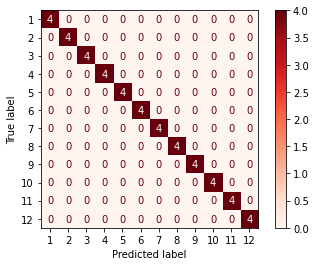

In [ ]:
#Search of the optimal parameter 'k' and scoring of both train and test set.
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
#Typical example of the research of the optimal parameters. The presented
#results are obtained with the optimal parameters found after some time
#consuming personal research.
parameters = {'n_neighbors':np.arange(3,50,1)}

#In this and each of the models presented in the following steps, the parameters
#used in the calculations were chosen according to the best results achieved
#by the hyperp_search function.

#parameters= {'n_neighbors':[410]}

hyperp_search2(classifier, parameters, 5, X_train, y_train, X_test, y_test)
#Application of the KNN classifier to the dataset with the optimal parameter
#found in the previous step and plotting ofthe ROC curve with its relative AUC score.

#model_knn = KNeighborsClassifier(n_neighbors=410)
#fpr0,tpr0=roc(model_knn,X_train,y_train,X_test,y_test)

#Decision Tree


  ***Best result obtained***  

accuracy (mean cross-validated score): 1.000000 using {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}

  ***Scores obtained on train and test sets with best model***  

accuracy    train 1.000   test 1.000

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


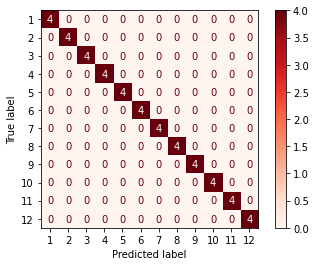

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [2,3,4,5,6],
              'min_samples_split': [5,10,20],
              'min_samples_leaf': [5,10,20]}

best_model_tree = hyperp_search2(classifier, parameters, 5, X_train, y_train, X_test, y_test)

#Application of the Decision Tree classifier to the dataset with the optimal
#parameters found in a grid-search step and plotting of the ROC curve with its
#relative AUC score.

#model_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, min_samples_split=10)
#fpr1,tpr1=roc(model_tree,X_train,y_train,X_test,y_test)


In [ ]:
r = tree.export_text(best_model_tree, feature_names=X_test.columns.tolist(), max_depth=5)
print(r)

|--- z_chest_avg <= 4.53
|   |--- y_chest_avg <= 11.42
|   |   |--- z_chest_avg <= -40.43
|   |   |   |--- class: 9
|   |   |--- z_chest_avg >  -40.43
|   |   |   |--- y_chest_avg <= -39.72
|   |   |   |   |--- class: 10
|   |   |   |--- y_chest_avg >  -39.72
|   |   |   |   |--- class: 12
|   |--- y_chest_avg >  11.42
|   |   |--- x_chest_avg <= 10.34
|   |   |   |--- class: 1
|   |   |--- x_chest_avg >  10.34
|   |   |   |--- x_chest_avg <= 16.93
|   |   |   |   |--- class: 3
|   |   |   |--- x_chest_avg >  16.93
|   |   |   |   |--- class: 2
|--- z_chest_avg >  4.53
|   |--- z_chest_avg <= 119.95
|   |   |--- z_ankle_avg <= -2.97
|   |   |   |--- class: 11
|   |   |--- z_ankle_avg >  -2.97
|   |   |   |--- y_chest_avg <= -119.59
|   |   |   |   |--- class: 8
|   |   |   |--- y_chest_avg >  -119.59
|   |   |   |   |--- class: 7
|   |--- z_chest_avg >  119.95
|   |   |--- z_ankle_avg <= -128.34
|   |   |   |--- class: 5
|   |   |--- z_ankle_avg >  -128.34
|   |   |   |--- z_chest_avg 

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
parameters = {"n_estimators":[16], "criterion":['entropy'], "max_depth":[20], "min_samples_split":[10], "min_samples_leaf":[5]}
best_model_rf = hyperp_search2(classifier, parameters, 5, X_train, y_train, X_test, y_test)
#rand_forest=RandomForestClassifier(n_estimators=40,criterion='entropy',max_depth=15,min_samples_split=20,min_samples_leaf=10)
#fpr2,tpr2=roc(rand_forest,X_train,y_train,X_test,y_test)

TypeError: ignored

# ADABOOST

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

classifier= AdaBoostClassifier()
parameters = {'n_estimators' : np.arange(1500,2500,500),
    'learning_rate' : [0.001,0.01,0.1]}

hyperp_search(classifier,parameters)

#adaboostclass = AdaBoostClassifier(n_estimators=2000, learning_rate=0.01)

#fpr3,tpr3=roc(adaboostclass,X_train,y_train,X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***GRIDSEARCH RESULTS***
f1_test:  1.0
[[4 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 4]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.

# LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[0.01,0.1,1],"max_iter":[10000],"penalty":['l2']}

hyperp_search(classifier,parameters)

#model_log = LogisticRegression(C=0.1, max_iter=10000, penalty='l2')

#fpr5,tpr5=roc(model_log,X_train,y_train,X_test,y_test)

##### ADABOOST WITH LOGISTIC REGRESSION

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

#classifier= AdaBoostClassifier()
#parameters = {'n_estimators' : [2000], 'algorithm':['SAMME'],
#    'learning_rate' : [0.01] , 'base_estimator':['LogisticRegression()']}

#hyperp_search(classifier,parameters)

adaboostclass = AdaBoostClassifier(n_estimators=2000, learning_rate=0.01, 
                                   base_estimator=LogisticRegression(C=0.1, max_iter=10000, penalty='l2'))
adaboostclass.fit(X_train, y_train)

y2_pred = adaboostclass.predict(X_test)

#y2=y_test.Target
print("f1_test: ", f1_score(y_test, y2_pred))
print(confusion_matrix(y_test, y2_pred))
print(classification_report(y_test, y2_pred))

fpr3,tpr3=roc(adaboostclass,X_train,y_train,X_test,y_test)

# SVM

In [ ]:
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear'], "C":[0.01,0.1]}

hyperp_search(classifier,parameters)

#model_svm = SVC(C=1, kernel='linear',probability=True)

#fpr6,tpr6=roc(model_svm,X_train,y_train,X_test,y_test)

# NEURAL NETWORK

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(10,8,5)],  "max_iter": [2500], "alpha": [1]}

hyperp_search(classifier,parameters)
#model_MLP=MLPClassifier(hidden_layer_sizes=(10,8,5), alpha=1, max_iter=5000)

#fpr7,tpr7=roc(model_MLP,X_train,y_train,X_test,y_test)

# ROC COMPLESSIVA

In [ ]:
plt.plot(fpr0, tpr0, label= "KNN")
plt.plot(fpr1, tpr1, label= "Tree")
plt.plot(fpr2, tpr2, label= "Forest")
plt.plot(fpr3, tpr3, label= "Adaboost")
#plt.plot(fpr4, tpr4, label= "Naive bayes")    
plt.plot(fpr5, tpr5, label= "Logistic")
plt.plot(fpr6, tpr6, label= "SVM")
plt.plot(fpr7, tpr7, label= "NeuralNet")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()